<a href="https://colab.research.google.com/github/imhyunho99/2023-1--Deaplearning_Framework/blob/main/Caltech101.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Settings
### 1) Import required libraries

In [18]:
!pip install pretrainedmodels

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60945 sha256=93e32b0ffde706bbf50eebaa4afcf3864fb2a277e283f668bb82234f72137186
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built pretrainedmodels


In [19]:
import matplotlib.pyplot as plt
import matplotlib
import argparse 
import joblib
import cv2
import os
import torch 
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
import pickle
import random
import torchvision
import pretrainedmodels

matplotlib.style.use('ggplot')

from imutils import paths
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from torchvision.transforms import transforms
from torch.utils.data import DataLoader, Dataset
from torchvision import models, datasets
from tqdm import tqdm

def seed_everything(SEED=42):
    random.seed(SEED)
    np.random.seed(SEED)
    torch.manual_seed(SEED)
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)

SEED=42
seed_everything(SEED=SEED)

### 2) Set hyperparameters

In [67]:
batch_size = 64
learning_rate = 0.0001
num_epoch = 4

## 2. Data

### 1) Download Data

In [4]:
data = datasets.Caltech101("./", download=True)

131740031it [00:01, 76674048.20it/s]


Extracting ./caltech101/101_ObjectCategories.tar.gz to ./caltech101


14028800it [00:00, 57206157.19it/s]


Extracting ./caltech101/Annotations.tar to ./caltech101


### 2) Check Dataset

In [5]:
image_paths = list(paths.list_images('./caltech101/101_ObjectCategories'))

data = []
labels = []
for img_path in tqdm(image_paths):
    label = img_path.split(os.path.sep)[-2] #라벨 위치
    if label == "BACKGROUND_Google":
        continue
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    data.append(img)
    labels.append(label)
    
data = np.array(data)
labels = np.array(labels)
    

100%|██████████| 9144/9144 [00:09<00:00, 933.72it/s]
<ipython-input-5-5755c013affe>:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data = np.array(data)


In [6]:
label_names = labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
print(len(lb.classes_))
print(labels)
print(label_names)

101
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
['pagoda' 'pagoda' 'pagoda' ... 'panda' 'panda' 'panda']


In [7]:
count_arr = []
label_arr = []
for i in range(len(lb.classes_)):
    count = 0
    for j in range(len(label_names)):
        if lb.classes_[i] in label_names[j]:
            count += 1
    count_arr.append(count)
    label_arr.append(lb.classes_[i])

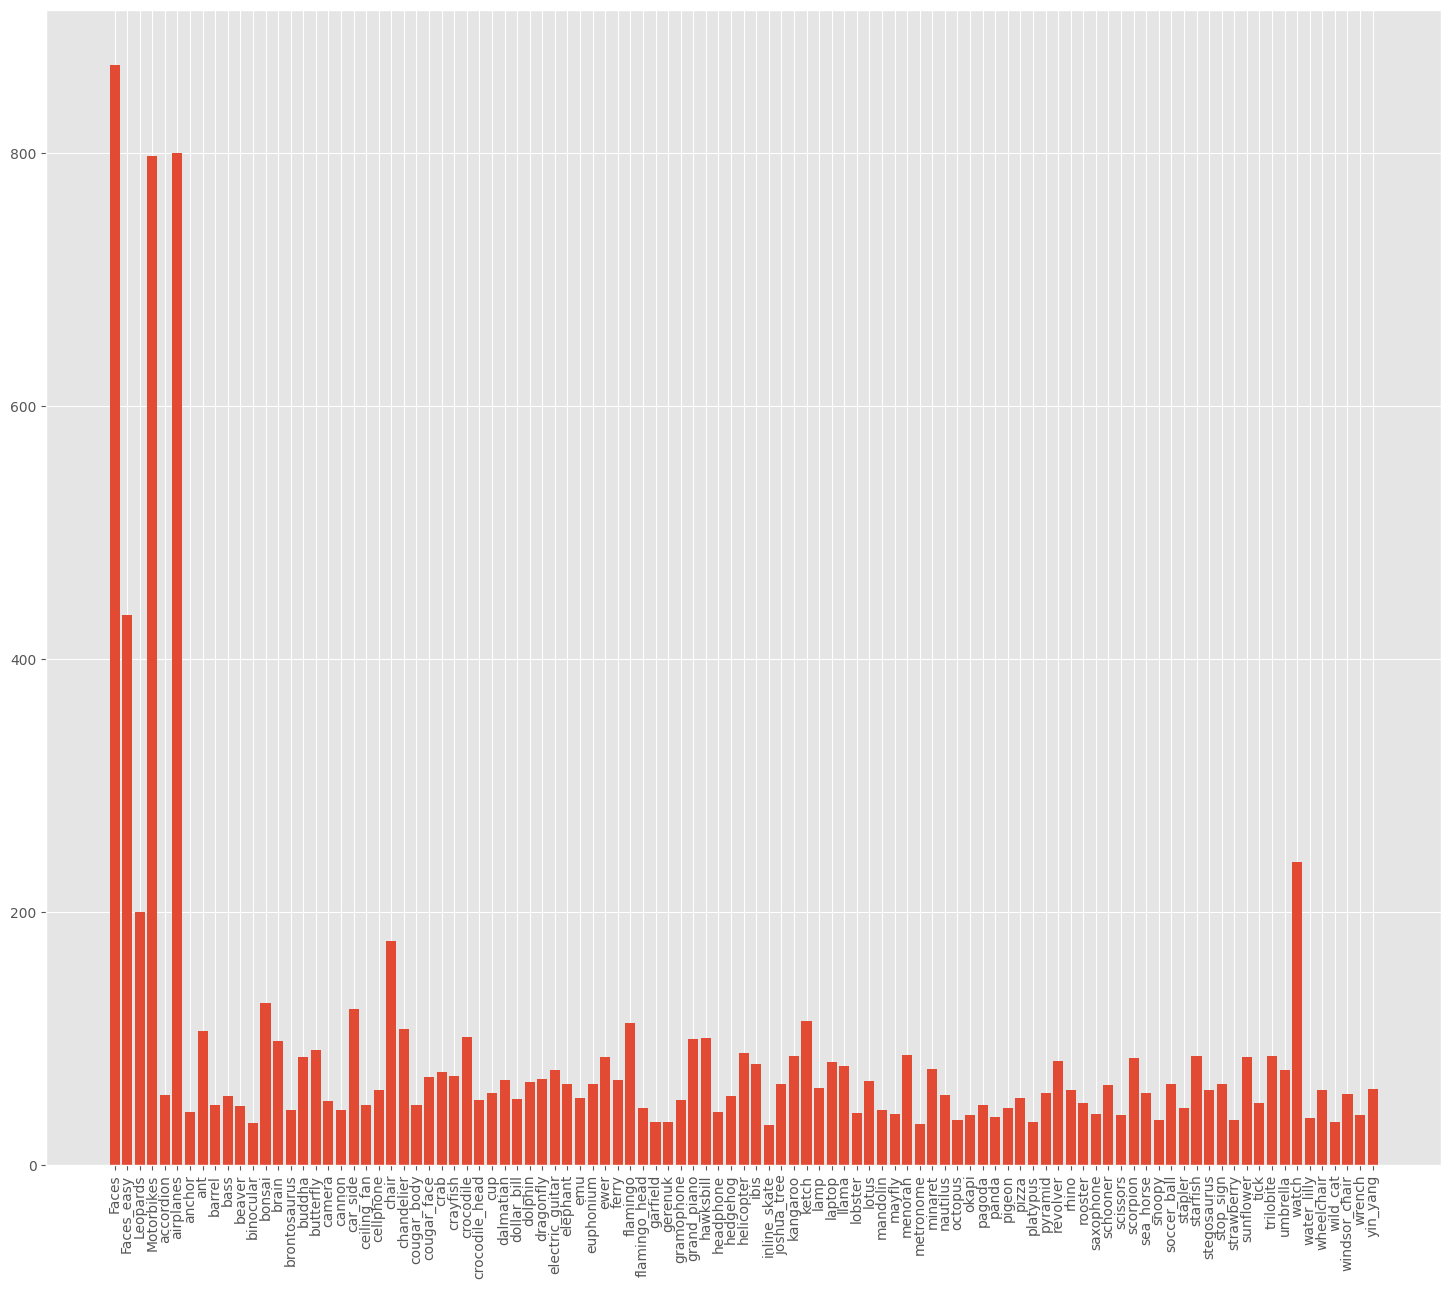

In [8]:
plt.figure(figsize=(18, 15))
plt.bar(label_arr, count_arr,)
plt.xticks(rotation='vertical')
plt.show()

### 3) Set DataLoader

In [9]:
# divide the data into train, validation, and test set
(x_train, x_test, y_train, y_test) = train_test_split(data, labels, test_size=0.2,  stratify=labels,random_state=42)
(x_train, x_val, y_train, y_val) = train_test_split(x_train, y_train, test_size=0.25, random_state=42)
print(f"x_train examples: {x_train.shape}\nx_test examples: {x_test.shape}\nx_val examples: {x_val.shape}")

x_train examples: (5205,)
x_test examples: (1736,)
x_val examples: (1736,)


In [10]:
class CustomDataset(Dataset): #pytorch에서 사용할 수 있는 Dset을 만들어줘야함
    def __init__(self, images, labels, transforms=None):
        self.x = images
        self.y = labels
        self.transforms = transforms
         
    def __len__(self):
        return (len(self.x))
    
    def __getitem__(self, i):
        data = self.x[i][:]
        
        if self.transforms is not None:
            data = self.transforms(data)
            
        return (data, self.y[i])

In [61]:
# define transforms
train_transform = transforms.Compose(
    [transforms.ToPILImage(),
     transforms.Resize((224, 224)),
     transforms.ToTensor(),
     transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225])])
val_transform = transforms.Compose(
    [transforms.ToPILImage(),
     transforms.Resize((224, 224)),
     transforms.ToTensor(),
     transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225])])

In [12]:
train_data = CustomDataset(x_train, y_train, train_transform)
val_data = CustomDataset(x_val, y_val, val_transform)
test_data = CustomDataset(x_test, y_test, val_transform)
 
# dataloaders
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, drop_last=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, drop_last=True)

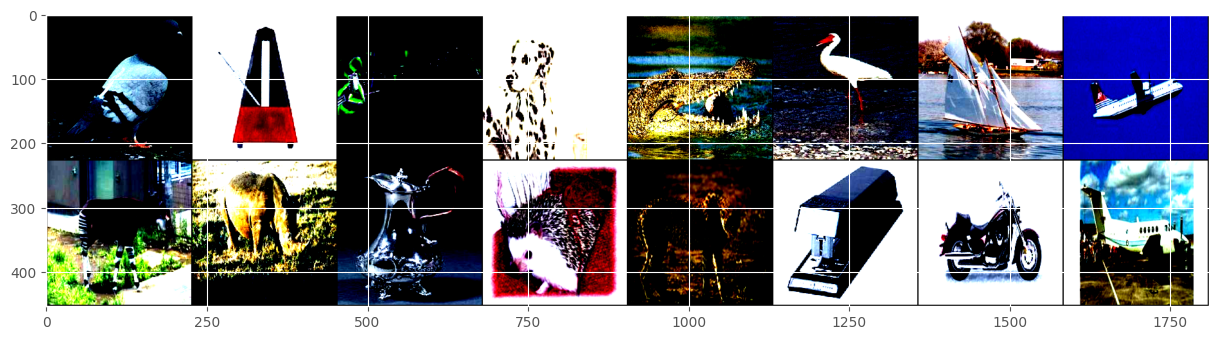

In [13]:
def imshow(img):
    plt.figure(figsize=(15, 12))
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
images, labels = next(iter(train_loader))

# show images
imshow(torchvision.utils.make_grid(images))

## 3. Model & Optimizer

### 1) CNN Model

In [68]:
# the resnet34 model
class ResNet34(nn.Module):
    def __init__(self, pretrained):
        super(ResNet34, self).__init__()
        if pretrained is True:
            self.model = pretrainedmodels.__dict__['resnet34'](pretrained='imagenet')
        else:
            self.model = pretrainedmodels.__dict__['resnet34'](pretrained=None)
        
        # change the classification layer
        self.l0 = nn.Linear(512, len(lb.classes_))
        self.dropout = nn.Dropout2d(0.4)
    def forward(self, x):
        # get the batch size only, ignore (c, h, w)
        batch, _, _, _ = x.shape
        x = self.model.features(x)
        x = F.adaptive_avg_pool2d(x, 1).reshape(batch, -1)
        x = self.dropout(x)
        l0 = self.l0(x)
        return l0
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


model = ResNet34(pretrained=True).to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


### 2) Loss func & Optimizer

In [69]:
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

## 4. Train 

In [70]:
def train(model, dataloader):
    model.train()
    train_running_loss = 0.0
    train_running_correct = 0
    for i, data in tqdm(enumerate(dataloader), total=int(len(train_data)/dataloader.batch_size)):
        data, target = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = model(data)
        loss = loss_func(outputs, torch.max(target, 1)[1])
        train_running_loss += loss.item()
        _, preds = torch.max(outputs.data, 1)
        train_running_correct += (preds == torch.max(target, 1)[1]).sum().item()
        loss.backward()
        optimizer.step()
        
    train_loss = train_running_loss/len(dataloader.dataset)
    train_accuracy = 100. * train_running_correct/len(dataloader.dataset)
    
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}")
    
    return train_loss, train_accuracy

In [71]:
def validate(model, dataloader):
    model.eval()
    val_running_loss = 0.0
    val_running_correct = 0
    with torch.no_grad():
        for i, data in tqdm(enumerate(dataloader), total=int(len(val_data)/dataloader.batch_size)):
            data, target = data[0].to(device), data[1].to(device)
            outputs = model(data)
            loss = loss_func(outputs, torch.max(target, 1)[1])
            val_running_loss += loss.item()
            _, preds = torch.max(outputs.data, 1)
            val_running_correct += (preds == torch.max(target, 1)[1]).sum().item()
        
        val_loss = val_running_loss/len(dataloader.dataset)
        val_accuracy = 100. * val_running_correct/len(dataloader.dataset)
        
        print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}')
        
        return val_loss, val_accuracy

In [72]:
train_loss , train_accuracy = [], []
val_loss , val_accuracy = [], []
start = time.time()
for epoch in range(num_epoch):
    print(f"Epoch {epoch+1} of {num_epoch}")
    train_epoch_loss, train_epoch_accuracy = train(model, train_loader)
    val_epoch_loss, val_epoch_accuracy = validate(model, val_loader)
    train_loss.append(train_epoch_loss)
    train_accuracy.append(train_epoch_accuracy)
    val_loss.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)
end = time.time()

print((end-start)/60, 'minutes')

Epoch 1 of 4


100%|██████████| 325/325 [00:29<00:00, 10.86it/s]


Train Loss: 0.1021, Train Acc: 67.13


100%|██████████| 108/108 [00:07<00:00, 14.84it/s]


Val Loss: 0.0261, Val Acc: 90.21
Epoch 2 of 4


100%|██████████| 325/325 [00:29<00:00, 11.07it/s]


Train Loss: 0.0186, Train Acc: 95.43


100%|██████████| 108/108 [00:06<00:00, 16.50it/s]


Val Loss: 0.0139, Val Acc: 94.59
Epoch 3 of 4


100%|██████████| 325/325 [00:29<00:00, 11.12it/s]


Train Loss: 0.0062, Train Acc: 98.50


100%|██████████| 108/108 [00:06<00:00, 15.76it/s]


Val Loss: 0.0117, Val Acc: 94.82
Epoch 4 of 4


100%|██████████| 325/325 [00:29<00:00, 11.14it/s]


Train Loss: 0.0036, Train Acc: 99.25


100%|██████████| 108/108 [00:06<00:00, 17.38it/s]

Val Loss: 0.0108, Val Acc: 95.28
2.411194058259328 minutes


In [73]:
torch.save(model.state_dict(), f"model_{num_epoch}.pth")

[67.12776176753123, 95.42747358309317, 98.5014409221902, 99.2507204610951]
[0.10212135940188977, 0.01855393267602559, 0.00615895769606263, 0.0035765894592044503]
[90.2073732718894, 94.5852534562212, 94.81566820276498, 95.27649769585254]
[0.02613840905374371, 0.013908481931373957, 0.011731902176561478, 0.01081597181450155]


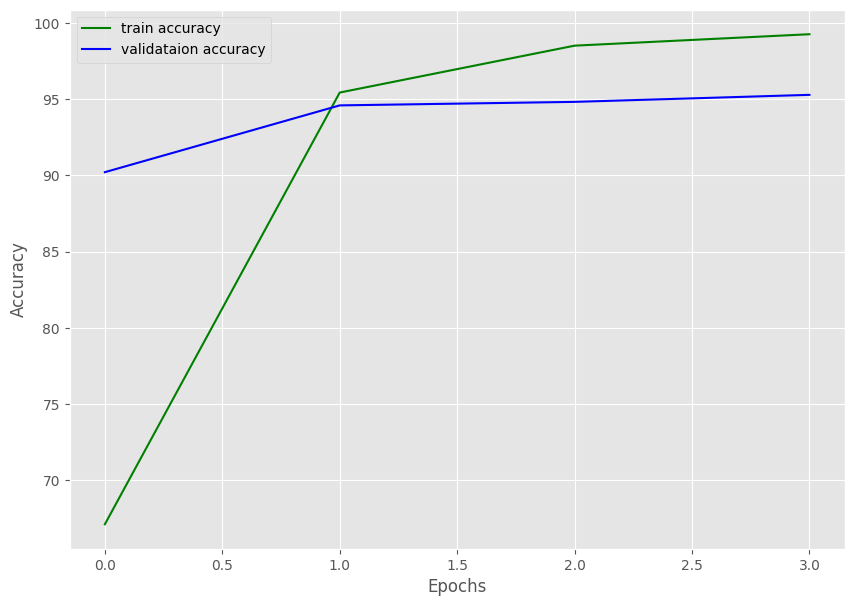

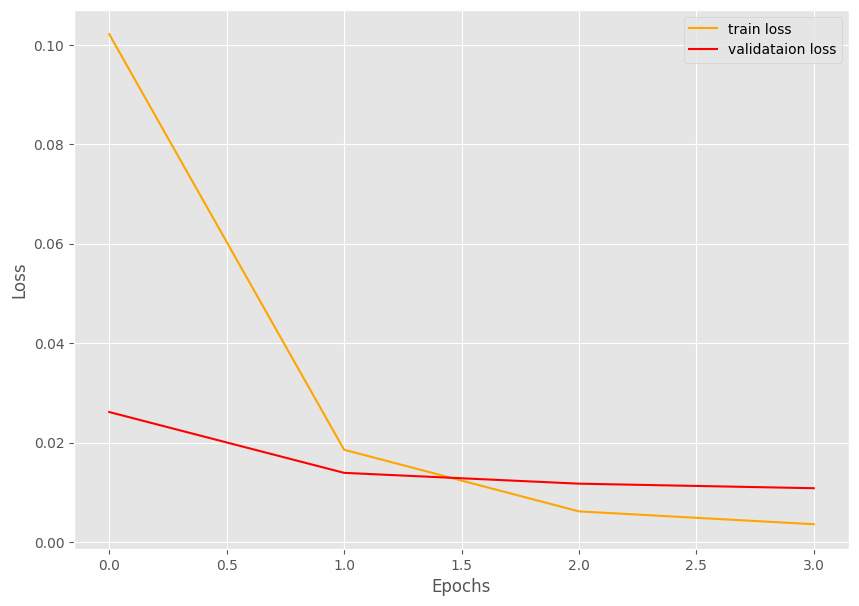

['val_loss.pkl']

In [74]:
print(train_accuracy)
print(train_loss)
print(val_accuracy)
print(val_loss)

# accuracy plots
plt.figure(figsize=(10, 7))
plt.plot(train_accuracy, color='green', label='train accuracy')
plt.plot(val_accuracy, color='blue', label='validataion accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('accuracy.png')
plt.show()

# loss plots
plt.figure(figsize=(10, 7))
plt.plot(train_loss, color='orange', label='train loss')
plt.plot(val_loss, color='red', label='validataion loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('loss.png')
plt.show()

import joblib
joblib.dump(train_accuracy, 'train_accuracy.pkl')
joblib.dump(train_loss, 'train_loss.pkl')
joblib.dump(val_accuracy, 'val_accuracy.pkl')
joblib.dump(val_loss, 'val_loss.pkl')

In [75]:
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        inputs = data[0].to(device, non_blocking=True)
        target = data[1].to(device, non_blocking=True)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += target.size(0)
        correct += (predicted == torch.max(target, 1)[1]).sum().item()

print('Accuracy of the network on test images: %0.3f %%' % (100 * correct / total))

Accuracy of the network on test images: 95.602 %


## 5.25까지 가장 높은 러닝 결과를 만들어 낼 것